# Evaluate Regression Models

## How did we get here? 

1. Acquire
2. Clean
3. Split
4. Scale
5. Explore

Goal: estimate/predict the number of COVID-19 cases in a county based on population at a point in time

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Wrangle

### Acquire + Clean

**Population**

Import the estimated population of each county in the U.S. This data comes from https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-total.html.

In [163]:
# import population_estimates_2019.csv
df_pop = pd.read_csv("population_estimates_2019.csv")

# select county, state, and population
df_pop = df_pop[['county', 'state', 'pop_est_2019']]

# rename columns to county, state, pop
df_pop.columns = ['county', 'state', 'pop']

# ensure no whitespaces
df_pop['state'] = df_pop.state.str.strip()
df_pop['county'] = df_pop.county.str.strip()

df_pop.head()

,county,state,pop
0,Autauga,Alabama,55869
1,Baldwin,Alabama,223234
2,Barbour,Alabama,24686
3,Bibb,Alabama,22394
4,Blount,Alabama,57826


In [159]:
df_pop.shape
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 3 columns):
county    3142 non-null object
state     3142 non-null object
pop       3142 non-null int64
dtypes: int64(1), object(2)
memory usage: 73.8+ KB


**Cases**

Import Covid-19 data for April 1, 2020, provided by Johns Hopkins (https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports/04-01-2020.csv)

In [160]:
# import covid19_04-01-2020.csv
df_cases = pd.read_csv('covid19_04-01-2020.csv')

# select US only 
df_cases = df_cases[df_cases.Country_Region == 'US']

# select county, state and cases
df_cases = df_cases[['Admin2', 'Province_State', 'Confirmed']]

# rename columns to county, state, cases
df_cases.columns = ['county','state','cases']

# drop nulls 
df_cases = df_cases[df_cases.county.isnull() == False]

# ensure no whitespace
df_cases['state'] = df_cases.state.str.strip()
df_cases['county'] = df_cases.county.str.strip()

df_cases.head()

,county,state,cases
0,Abbeville,South Carolina,4
1,Acadia,Louisiana,47
2,Accomack,Virginia,7
3,Ada,Idaho,195
4,Adair,Iowa,1


In [162]:
print(df_cases.shape)
df_cases.info()

(2223, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2223 entries, 0 to 2222
Data columns (total 3 columns):
county    2223 non-null object
state     2223 non-null object
cases     2223 non-null int64
dtypes: int64(1), object(2)
memory usage: 69.5+ KB


**Merge dataframes on county and state**

In [164]:
df = pd.merge(df_cases, df_pop, how="inner")

### Summarize

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 2067
Data columns (total 4 columns):
county    2068 non-null object
state     2068 non-null object
cases     2068 non-null int64
pop       2068 non-null int64
dtypes: int64(2), object(2)
memory usage: 80.8+ KB


In [166]:
df.head()

,county,state,cases,pop
0,Abbeville,South Carolina,4,24527
1,Accomack,Virginia,7,32316
2,Ada,Idaho,195,481587
3,Adair,Iowa,1,7152
4,Adair,Missouri,3,25343


In [167]:
df.describe()

,cases,pop
count,2068.000000,2.068000e+03
mean,72.327853,1.430795e+05
std,445.251117,3.939480e+05
min,0.000000,7.690000e+02
25%,2.000000,1.998900e+04
50%,5.000000,4.271700e+04
75%,20.250000,1.097912e+05
max,10683.000000,1.003911e+07


**Distributions using .hist()**

Cases

In [2]:
df.cases.hist(bins=60)

NameError: name 'df' is not defined

Population

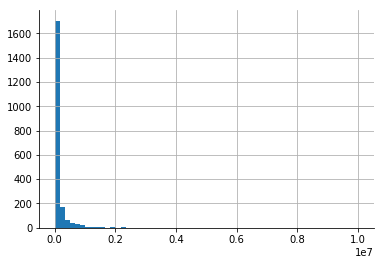

In [171]:
df['pop'].hist(bins=60)

Both distributions are heavily skewed right, as we would expect.

### Split into train and test dataset

In [172]:
from sklearn.model_selection import train_test_split
seed = 444

train, test = train_test_split(df, train_size=.80, random_state=seed)

print(train.shape, test.shape)

(1654, 4) (414, 4)


### Scale

Why is it not necessary to scale? 

## Explore

## Model

### Feature Selection

Not needed in this case, as only 1 variable

### Evaluate baseline "performance" our model must "beat" to make it worthwhile

We will use the Root Mean Squared Error as our evaluation metric. 

Our baseline could be predicting the mean, the median, a value that must be met by the stakeholder, or the performance a current model is performing at, as examples. We will use the median here. Why would we choose median over mean? 

In [ ]:
# select cases & population only 

train = train[['cases','pop']]
train.columns = ['y', 'x']
train.head()

In [179]:
train['yhat_bl'] = train.y.median()

train['yhat_mean'] = train.y.mean()

Use scikit-learn to compute RMSE: sklearn.metrics.mean_squared_error

In [180]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_bl = sqrt(mean_squared_error(train.y, train.yhat_bl))
rmse_mean = sqrt(mean_squared_error(train.y, train.yhat_mean))

In [181]:
print(rmse_bl, rmse_mean)

410.96540644712604 405.65003924646084


### Build a simple linear regression model

This is clearly NOT a simple ordinary linear regression problem...why?
But for simplicity, we will do a simple linear model. 

In [182]:
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('y ~ x', data = train).fit()

# compute predictions and add to original dataframe
train['yhat'] = ols_model.predict(x)
train.head(3)

,y,x,yhat_bl,yhat_mean,yhat
470,27,71522,5.0,70.883313,31.794196
1661,7,41170,5.0,70.883313,15.697590
465,1,14029,5.0,70.883313,1.303876


In [183]:
rmse = sqrt(mean_squared_error(train.y, train.yhat))
rmse

339.46629092939565

### Evaluate our Linear Model

In [185]:
# compute evs
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(train.y, train.yhat)
evs

0.2996901000713923

In [189]:
# get r^2
print(ols_model.rsquared)

# get p-value from f_pvalue
print(ols_model.f_pvalue)

0.2996901000713922
5.80338309565854e-130


In [190]:
# or just view r^2 and P-value here: 
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     707.0
Date:                Thu, 02 Apr 2020   Prob (F-statistic):          5.80e-130
Time:                        15:39:25   Log-Likelihood:                -11985.
No. Observations:                1654   AIC:                         2.397e+04
Df Residuals:                    1652   BIC:                         2.399e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.1361      8.840     -0.694      0.488     -23.475      11.203
x              0.0005   1.99e-05     26.589      0.000       0.000       0.001
==============================================================================
Omnibus:                     3445.551   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10564671.854
Skew:                          17.083   Prob(JB):                         0.00
Kurtosis:                     393.037   Cond. No.                     4.69e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.69e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""